In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report

# Activation functions
def relu(x):
    """ReLU activation: max(0, x)"""
    assert isinstance(x, np.ndarray), "Input to ReLU must be a numpy array"
    result = np.maximum(0, x)
    assert np.all(result >= 0), "ReLU output must be non-negative"
    return result

def relu_derivative(x):
    """Derivative of ReLU: 1 if x > 0, else 0"""
    assert isinstance(x, np.ndarray), "Input to ReLU derivative must be a numpy array"
    result = np.where(x > 0, 1, 0)
    assert np.all((result == 0) | (result == 1)), "ReLU derivative must be 0 or 1"
    return result

def softmax(x):
    """Softmax activation: exp(x) / sum(exp(x))"""
    assert isinstance(x, np.ndarray), "Input to softmax must be a numpy array"
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    result = exp_x / np.sum(exp_x, axis=1, keepdims=True)
    assert np.all((result >= 0) & (result <= 1)), "Softmax output must be in [0,1]"
    assert np.allclose(np.sum(result, axis=1), 1), "Softmax output must sum to 1 per sample"
    return result

# Data augmentation function
def augment_image(image, max_rotation=10, max_translation=3):
    """Apply random rotation and translation to a 32x32 grayscale image"""
    assert image.shape == (32, 32), "Image must be 32x32"
    angle = np.random.uniform(-max_rotation, max_rotation)
    M = cv2.getRotationMatrix2D((16, 16), angle, 1.0)
    rotated = cv2.warpAffine(image, M, (32, 32), borderMode=cv2.BORDER_REPLICATE)
    tx = np.random.uniform(-max_translation, max_translation)
    ty = np.random.uniform(-max_translation, max_translation)
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    translated = cv2.warpAffine(rotated, M, (32, 32), borderMode=cv2.BORDER_REPLICATE)
    return translated.flatten()

def load_and_preprocess_image(image_path, target_size=(32, 32)):
    """
    Load and preprocess an image : convert to grayscale , resize , normalize
    """

    assert os.path.exists(image_path), f" Image not found : {image_path }"
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    assert img is not None , f" Failed to load image : { image_path }"
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0
    return img.flatten()

class MulticlassNeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.001, l2_lambda=0.01, optimizer='sgd', beta1=0.9, beta2=0.999, epsilon=1e-8):
        """Initialize the neural network with layer sizes, learning rate, L2 regularization, and optimizer"""
        assert isinstance(layer_sizes, list) and len(layer_sizes) >= 2, "layer_sizes must be a list with at least 2 elements"
        assert all(isinstance(size, int) and size > 0 for size in layer_sizes), "All layer sizes must be positive integers"
        assert isinstance(learning_rate, (int, float)) and learning_rate > 0, "Learning rate must be a positive number"
        assert isinstance(l2_lambda, (int, float)) and l2_lambda >= 0, "Regularization lambda must be non-negative"
        assert optimizer.lower() in ['sgd', 'adam'], "Optimizer must be 'sgd' or 'adam'"

        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.l2_lambda = l2_lambda
        self.optimizer = optimizer.lower()
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.weights = []
        self.biases = []
        self.z_values = []
        self.activations = []
        self.d_weights = []
        self.d_biases = []
        self.m_weights = []
        self.v_weights = []
        self.m_biases = []
        self.v_biases = []
        self.t = 0

        # Initialize weights and biases
        np.random.seed(42)
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * np.sqrt(2 / layer_sizes[i])  # He initialization
            b = np.zeros((1, layer_sizes[i + 1]))
            self.weights.append(w)
            self.biases.append(b)
            self.m_weights.append(np.zeros_like(w))
            self.v_weights.append(np.zeros_like(w))
            self.m_biases.append(np.zeros_like(b))
            self.v_biases.append(np.zeros_like(b))

    def forward(self, X):
        """Forward propagation: Z^[l] = A^[l-1] W^[l] + b^[l], A^[l] = g(Z^[l])"""
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"

        self.z_values = []
        self.activations = [X]

        for i in range(len(self.weights) - 1):
            Z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            assert Z.shape == (X.shape[0], self.layer_sizes[i + 1]), f"Z^{[i+1]} has incorrect shape"
            self.z_values.append(Z)
            self.activations.append(relu(Z))

        Z = np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]
        assert Z.shape == (X.shape[0], self.layer_sizes[-1]), "Output Z has incorrect shape"
        self.z_values.append(Z)
        output = softmax(Z)
        assert output.shape == (X.shape[0], self.layer_sizes[-1]), "Output A has incorrect shape"
        self.activations.append(output)
        return self.activations[-1]

    def compute_loss(self, y_true, y_pred):
        """Compute cross-entropy loss with L2 regularization"""
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Inputs to loss must be numpy arrays"
        assert y_true.shape == y_pred.shape, f"y_true ({y_true.shape}) and y_pred ({y_pred.shape}) must have the same shape"

        m = y_true.shape[0]
        epsilon = 1e-15
        y_pred_clipped = np.clip(y_pred, epsilon, 1 - epsilon)

        # Cross-entropy loss
        cross_entropy = -np.sum(y_true * np.log(y_pred_clipped)) / m

        # L2 regularization term
        l2_term = 0
        if hasattr(self, 'l2_lambda') and self.l2_lambda > 0:
            for W in self.weights:
                assert isinstance(W, np.ndarray), "Each weight must be a numpy array"
                l2_term += np.sum(np.square(W))
            l2_term *= (self.l2_lambda / (2 * m))

        total_loss = cross_entropy + l2_term

        # Assertions for robustness
        assert not np.isnan(total_loss), "Loss computation resulted in NaN"
        assert not np.isinf(total_loss), "Loss computation resulted in Inf"
        assert total_loss >= 0, "Loss must be non-negative"

        return np.squeeze(total_loss)

    def compute_accuracy(self, y_true, y_pred):
        """Compute accuracy: proportion of correct predictions"""
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Inputs to accuracy must be numpy arrays"
        assert y_true.shape == y_pred.shape, f"y_true ({y_true.shape}) and y_pred ({y_pred.shape}) must have the same shape"

        predictions = np.argmax(y_pred, axis=1)
        true_labels = np.argmax(y_true, axis=1)
        accuracy = np.mean(predictions == true_labels)

        assert 0 <= accuracy <= 1, f"Accuracy must be between 0 and 1, got {accuracy}"
        return accuracy

    def backward(self, X, y):
        """Backpropagation: compute dW^[l], db^[l] for each layer"""
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray), "Inputs to backward must be numpy arrays"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        outputs = self.activations[-1]
        assert y.shape == outputs.shape, f"y ({y.shape}) and outputs ({outputs.shape}) must have the same shape"

        m = X.shape[0]
        self.d_weights = [np.zeros_like(w) for w in self.weights]
        self.d_biases = [np.zeros_like(b) for b in self.biases]

        # Output layer (softmax + cross-entropy)
        dZ = outputs - y
        assert dZ.shape == outputs.shape, "dZ for output layer has incorrect shape"
        self.d_weights[-1] = (np.dot(self.activations[-2].T, dZ) + self.l2_lambda * self.weights[-1]) / m
        self.d_biases[-1] = np.sum(dZ, axis=0, keepdims=True) / m

        # Hidden layers
        dA_prev = dZ
        for i in range(len(self.weights) - 2, -1, -1):
            dA = np.dot(dA_prev, self.weights[i + 1].T)
            dZ = dA * relu_derivative(self.z_values[i])
            assert dZ.shape == (X.shape[0], self.layer_sizes[i + 1]), f"dZ for layer {i+1} has incorrect shape"
            self.d_weights[i] = (np.dot(self.activations[i].T, dZ) + self.l2_lambda * self.weights[i]) / m
            self.d_biases[i] = np.sum(dZ, axis=0, keepdims=True) / m
            dA_prev = dZ

    def update_parameters(self):
        """Update weights and biases using the selected optimizer (SGD or Adam)"""
        if self.optimizer == 'sgd':
            for i in range(len(self.weights)):
                self.weights[i] -= self.learning_rate * self.d_weights[i]
                self.biases[i] -= self.learning_rate * self.d_biases[i]
        elif self.optimizer == 'adam':
            self.t += 1
            for i in range(len(self.weights)):
                self.m_weights[i] = self.beta1 * self.m_weights[i] + (1 - self.beta1) * self.d_weights[i]
                self.m_biases[i] = self.beta1 * self.m_biases[i] + (1 - self.beta1) * self.d_biases[i]
                self.v_weights[i] = self.beta2 * self.v_weights[i] + (1 - self.beta2) * (self.d_weights[i] ** 2)
                self.v_biases[i] = self.beta2 * self.v_biases[i] + (1 - self.beta2) * (self.d_biases[i] ** 2)
                m_w_hat = self.m_weights[i] / (1 - self.beta1 ** self.t)
                m_b_hat = self.m_biases[i] / (1 - self.beta1 ** self.t)
                v_w_hat = self.v_weights[i] / (1 - self.beta2 ** self.t)
                v_b_hat = self.v_biases[i] / (1 - self.beta2 ** self.t)
                self.weights[i] -= self.learning_rate * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
                self.biases[i] -= self.learning_rate * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)
        else:
            raise ValueError("Unsupported optimizer. Use 'sgd' or 'adam'.")

    def train(self, X, y, X_val, y_val, epochs, batch_size, augment=False):
        """
        Train with mini-batch SGD or Adam, with optional data augmentation and early stopping
        """
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray), "X and y must be numpy arrays"
        assert isinstance(X_val, np.ndarray) and isinstance(y_val, np.ndarray), "X_val and y_val must be numpy arrays"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y.shape[1] == self.layer_sizes[-1], f"Output dimension ({y.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"
        assert X_val.shape[1] == self.layer_sizes[0], f"Validation input dimension ({X_val.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y_val.shape[1] == self.layer_sizes[-1], f"Validation output dimension ({y_val.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"
        assert isinstance(epochs, int) and epochs > 0, "Epochs must be a positive integer"
        assert isinstance(batch_size, int) and batch_size > 0, "Batch size must be a positive integer"

        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        best_val_loss = np.inf
        patience_counter = 0

        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            epoch_loss = 0
            for i in range(0, X.shape[0], batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]
                if augment:
                    X_batch_aug = np.array([augment_image(x.reshape(32, 32)) for x in X_batch])
                else:
                    X_batch_aug = X_batch
                outputs = self.forward(X_batch_aug)
                epoch_loss += self.compute_loss(y_batch, outputs)
                self.backward(X_batch_aug, y_batch)
                self.update_parameters()

            train_loss = epoch_loss / (X.shape[0] // batch_size)
            train_pred = self.forward(X)
            train_accuracy = self.compute_accuracy(y, train_pred)
            val_pred = self.forward(X_val)
            val_loss = self.compute_loss(y_val, val_pred)
            val_accuracy = self.compute_accuracy(y_val, val_pred)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                      f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

        return train_losses, val_losses, train_accuracies, val_accuracies

    def predict(self, X):
        """
        Predict class labels
        """
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        outputs = self.forward(X)
        predictions = np.argmax(outputs, axis=1)
        assert predictions.shape == (X.shape[0],), "Predictions have incorrect shape"
        return predictions

def k_fold_cross_validation(X, y, layer_sizes, k=5, epochs=100, batch_size=32, learning_rate=0.001, l2_lambda=0.01, optimizer='sgd', augment=False):
    """Perform k-fold cross-validation"""
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_train_losses = []
    fold_val_losses = []
    fold_train_accuracies = []
    fold_val_accuracies = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"\n============================= Fold {fold + 1}/{k} ==================================")
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        one_hot_encoder = OneHotEncoder(sparse_output=False)
        y_train_one_hot = np.array(one_hot_encoder.fit_transform(y_train.reshape(-1, 1)))
        y_val_one_hot = np.array(one_hot_encoder.transform(y_val.reshape(-1, 1)))

        nn = MulticlassNeuralNetwork(layer_sizes, learning_rate=learning_rate, l2_lambda=l2_lambda, optimizer=optimizer)
        train_losses, val_losses, train_accuracies, val_accuracies = nn.train(
            X_train, y_train_one_hot, X_val, y_val_one_hot, epochs=epochs, batch_size=batch_size, augment=augment
        )

        fold_train_losses.append(train_losses)
        fold_val_losses.append(val_losses)
        fold_train_accuracies.append(train_accuracies)
        fold_val_accuracies.append(val_accuracies)

        y_val_pred = nn.predict(X_val)
        print(f"\n================== Fold {fold + 1} Classification Report:==========================")
        print(classification_report(np.argmax(y_val_one_hot, axis=1), y_val_pred))

    avg_train_losses = np.mean(fold_train_losses, axis=0)
    avg_val_losses = np.mean(fold_val_losses, axis=0)
    avg_train_accuracies = np.mean(fold_train_accuracies, axis=0)
    avg_val_accuracies = np.mean(fold_val_accuracies, axis=0)

    return avg_train_losses, avg_val_losses, avg_train_accuracies, avg_val_accuracies


In [2]:
# For Colab: Mount Google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Running in Google Colab with Google Drive mounted.")
    data_dir = "/content/drive/MyDrive/Master/DataSets/amhcd-data-64"
except ImportError:
    # For Jupyter: Assume dataset is manually placed in the runtime
    print("Running in Jupyter Notebook. Ensure dataset is in ../DataSets/amhcd-data-64/")
    data_dir = "../DataSets/amhcd-data-64"  # Adjust if placed elsewhere

Running in Jupyter Notebook. Ensure dataset is in ../DataSets/amhcd-data-64/


In [3]:
# Check if labels CSV exists
labels_csv_path = os.path.join(data_dir, "labels-map.csv")
if not os.path.exists(labels_csv_path):
    print(f"labels-map.csv not found at {labels_csv_path}. Building DataFrame from directory structure.")
    image_paths = []
    labels = []
    tifinagh_dir = os.path.join(data_dir, "tifinagh-images")
    if not os.path.exists(tifinagh_dir):
        raise FileNotFoundError(f"Tifinagh images directory not found at {tifinagh_dir}")
    for label_dir in os.listdir(tifinagh_dir):
        label_path = os.path.join(tifinagh_dir, label_dir)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                image_paths.append(os.path.join("tifinagh-images", label_dir, img_name))
                labels.append(label_dir)
    labels_df = pd.DataFrame({'image_path': image_paths, 'label': labels})
else:
    print(f"Loading csv file from {labels_csv_path} .")
    labels_df = pd.read_csv(labels_csv_path, names=['image_path', 'label'])

assert not labels_df.empty, "No data loaded . Check dataset files ."

Loading csv file from ../DataSets/amhcd-data-64\labels-map.csv .


In [4]:
labels_df

,image_path,label
0,./images-data-64/tifinagh-images/ya/tifinagh_1...,ⴰ
1,./images-data-64/tifinagh-images/ya/tifinagh_2...,ⴰ
2,./images-data-64/tifinagh-images/ya/tifinagh_3...,ⴰ
3,./images-data-64/tifinagh-images/ya/tifinagh_4...,ⴰ
4,./images-data-64/tifinagh-images/ya/tifinagh_5...,ⴰ
...,...,...
28177,./images-data-64/tifinagh-images/yazz/tifinagh...,ⵥ
28178,./images-data-64/tifinagh-images/yazz/tifinagh...,ⵥ
28179,./images-data-64/tifinagh-images/yazz/tifinagh...,ⵥ
28180,./images-data-64/tifinagh-images/yazz/tifinagh...,ⵥ


In [4]:
# Removing the ./images-data-64/ prefix from image_path values in the CSV
labels_df['image_path'] = labels_df['image_path'].apply(lambda x: x.replace('./images-data-64/', '') if isinstance(x, str) else x)

# Debugging: Print sample paths
print("Sample image paths:")
for path in labels_df['image_path'].head(5):
    full_path = os.path.join(data_dir, path)
    print(f"{full_path} -> Exists: {os.path.exists(full_path)}")

print(f"\nLoaded {len(labels_df)} samples with {labels_df['label'].nunique ()} unique classes .")

Sample image paths:
../DataSets/amhcd-data-64\tifinagh-images/ya/tifinagh_1.jpeg -> Exists: True
../DataSets/amhcd-data-64\tifinagh-images/ya/tifinagh_2.jpeg -> Exists: True
../DataSets/amhcd-data-64\tifinagh-images/ya/tifinagh_3.jpeg -> Exists: True
../DataSets/amhcd-data-64\tifinagh-images/ya/tifinagh_4.jpeg -> Exists: True
../DataSets/amhcd-data-64\tifinagh-images/ya/tifinagh_5.jpeg -> Exists: True

Loaded 28182 samples with 33 unique classes .


In [5]:
print("Label encoding ...")
# Encode labels
label_encoder = LabelEncoder()
labels_df['label_encoded'] = label_encoder.fit_transform(labels_df['label'])
num_classes = len(label_encoder.classes_)

print("============ Data with label encoded: ==============")
labels_df

Label encoding ...
============ Data with label encoded: ==============


,image_path,label,label_encoded
0,tifinagh-images/ya/tifinagh_1.jpeg,ⴰ,0
1,tifinagh-images/ya/tifinagh_2.jpeg,ⴰ,0
2,tifinagh-images/ya/tifinagh_3.jpeg,ⴰ,0
3,tifinagh-images/ya/tifinagh_4.jpeg,ⴰ,0
4,tifinagh-images/ya/tifinagh_5.jpeg,ⴰ,0
...,...,...,...
28177,tifinagh-images/yazz/tifinagh_28178.jpeg,ⵥ,32
28178,tifinagh-images/yazz/tifinagh_28179.jpeg,ⵥ,32
28179,tifinagh-images/yazz/tifinagh_28180.jpeg,ⵥ,32
28180,tifinagh-images/yazz/tifinagh_28181.jpeg,ⵥ,32


In [6]:
# Load images
X = np.array([load_and_preprocess_image(os.path.join(data_dir, path)) for path in labels_df['image_path']])
y = labels_df ['label_encoded'].values

# Verify dimensions
assert X.shape[0] == y.shape[0], "Mismatch between number of images and labels"
assert X.shape[1] == 32 * 32, f"Expected flattened image size of {32 * 32}, got {X.shape[1]}"


In [7]:
# Split into train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [8]:
# Perform k-fold cross-validation with SGD
layer_sizes = [32 * 32, 64, 32, num_classes]
print("\nK-Fold Cross-Validation with SGD:")
avg_train_losses_sgd, avg_val_losses_sgd, avg_train_accuracies_sgd, avg_val_accuracies_sgd = k_fold_cross_validation(
    X_temp, y_temp, layer_sizes, k=5, epochs=100, batch_size=32, learning_rate=0.001, l2_lambda=0.01, optimizer='sgd', augment=True
)


K-Fold Cross-Validation with SGD:

============================= Fold 1/5 ==================================
Epoch 0, Train Loss: 3.5533, Val Loss: 3.5012, Train Acc: 0.0347, Val Acc: 0.0288
Epoch 10, Train Loss: 3.3897, Val Loss: 3.2732, Train Acc: 0.1071, Val Acc: 0.1036
Epoch 20, Train Loss: 3.1799, Val Loss: 2.9790, Train Acc: 0.1680, Val Acc: 0.1677
Epoch 30, Train Loss: 2.9675, Val Loss: 2.6869, Train Acc: 0.2556, Val Acc: 0.2460
Epoch 40, Train Loss: 2.7768, Val Loss: 2.4343, Train Acc: 0.3296, Val Acc: 0.3220
Epoch 50, Train Loss: 2.6126, Val Loss: 2.2484, Train Acc: 0.3769, Val Acc: 0.3706
Epoch 60, Train Loss: 2.4890, Val Loss: 2.1012, Train Acc: 0.4119, Val Acc: 0.4016
Epoch 70, Train Loss: 2.3761, Val Loss: 1.9809, Train Acc: 0.4363, Val Acc: 0.4327
Epoch 80, Train Loss: 2.2684, Val Loss: 1.8751, Train Acc: 0.4668, Val Acc: 0.4604
Epoch 90, Train Loss: 2.1829, Val Loss: 1.7894, Train Acc: 0.4898, Val Acc: 0.4833

================== Fold 1 Classification Report:============

In [ ]:
# Perform k-fold cross-validation with Adam
print("\nK-Fold Cross-Validation with Adam:")
avg_train_losses_adam, avg_val_losses_adam, avg_train_accuracies_adam, avg_val_accuracies_adam = k_fold_cross_validation(
    X_temp, y_temp, layer_sizes, k=5, epochs=100, batch_size=32, learning_rate=0.001, l2_lambda=0.01, optimizer='adam', augment=True
)



K-Fold Cross-Validation with Adam:

============================= Fold 1/5 ==================================
Epoch 0, Train Loss: 2.8509, Val Loss: 1.9855, Train Acc: 0.4235, Val Acc: 0.4291
Epoch 10, Train Loss: 1.2004, Val Loss: 0.8612, Train Acc: 0.7349, Val Acc: 0.7297
Epoch 20, Train Loss: 1.0138, Val Loss: 0.6616, Train Acc: 0.7880, Val Acc: 0.7889
Epoch 30, Train Loss: 0.9433, Val Loss: 0.5897, Train Acc: 0.8172, Val Acc: 0.8139
Epoch 40, Train Loss: 0.8898, Val Loss: 0.5903, Train Acc: 0.8047, Val Acc: 0.8033
Epoch 50, Train Loss: 0.8527, Val Loss: 0.5446, Train Acc: 0.8236, Val Acc: 0.8210
Epoch 60, Train Loss: 0.8283, Val Loss: 0.4860, Train Acc: 0.8458, Val Acc: 0.8436
Epoch 70, Train Loss: 0.8134, Val Loss: 0.4745, Train Acc: 0.8536, Val Acc: 0.8479
Epoch 80, Train Loss: 0.7892, Val Loss: 0.4602, Train Acc: 0.8664, Val Acc: 0.8554


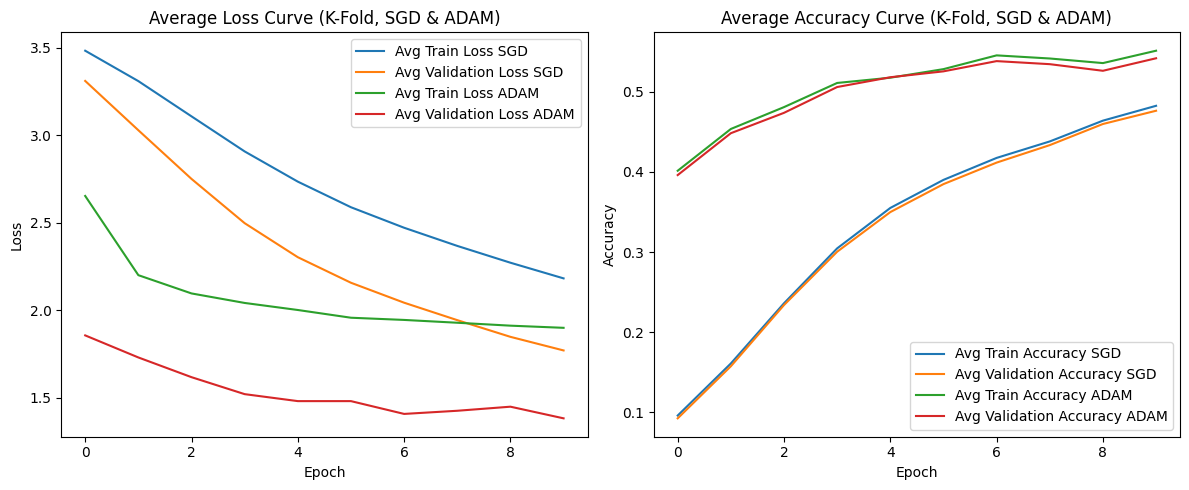

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(avg_train_losses_sgd, label='Avg Train Loss SGD')
ax1.plot(avg_val_losses_sgd, label='Avg Validation Loss SGD')
ax1.plot(avg_train_losses_adam, label='Avg Train Loss ADAM')
ax1.plot(avg_val_losses_adam, label='Avg Validation Loss ADAM')
ax1.set_title('Average Loss Curve (K-Fold, SGD & ADAM)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(avg_train_accuracies_sgd, label='Avg Train Accuracy SGD')
ax2.plot(avg_val_accuracies_sgd, label='Avg Validation Accuracy SGD')
ax2.plot(avg_train_accuracies_adam, label='Avg Train Accuracy ADAM')
ax2.plot(avg_val_accuracies_adam, label='Avg Validation Accuracy ADAM')
ax2.set_title('Average Accuracy Curve (K-Fold, SGD & ADAM)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.tight_layout()

In [20]:
# Train final model with Adam on full train+val set
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_temp_one_hot = np.array(one_hot_encoder.fit_transform(y_temp.reshape(-1, 1)))
y_test_one_hot = np.array(one_hot_encoder.transform(y_test.reshape(-1, 1)))

nn = MulticlassNeuralNetwork(layer_sizes, learning_rate=0.001, l2_lambda=0.01, optimizer='adam')
train_losses, val_losses, train_accuracies, val_accuracies = nn.train(
    X_temp, y_temp_one_hot, X_test, y_test_one_hot, epochs=100, batch_size=32, augment=True
)


Epoch 0, Train Loss: 2.7777, Val Loss: 1.8812, Train Acc: 0.4358, Val Acc: 0.4316



Final Test Set Classification Report:
              precision    recall  f1-score   support

           ⴰ       0.72      0.92      0.81       171
           ⴱ       0.56      0.54      0.55       171
           ⴳ       0.90      0.72      0.80       171
          ⴳⵯ       0.95      0.87      0.91       171
           ⴷ       0.76      0.85      0.81       171
           ⴹ       0.49      0.68      0.57       171
           ⴻ       0.64      0.52      0.57       171
           ⴼ       0.77      0.83      0.80       171
           ⴽ       0.89      0.69      0.78       170
          ⴽⵯ       0.85      0.91      0.88       170
           ⵀ       0.77      0.77      0.77       171
           ⵃ       0.86      0.87      0.86       171
           ⵄ       0.91      0.79      0.84       171
           ⵅ       0.77      0.81      0.79       171
           ⵇ       0.72      0.72      0.72       171
           ⵉ       0.61      0.49      0.54       170
           ⵊ       0.66      0.71      0.6

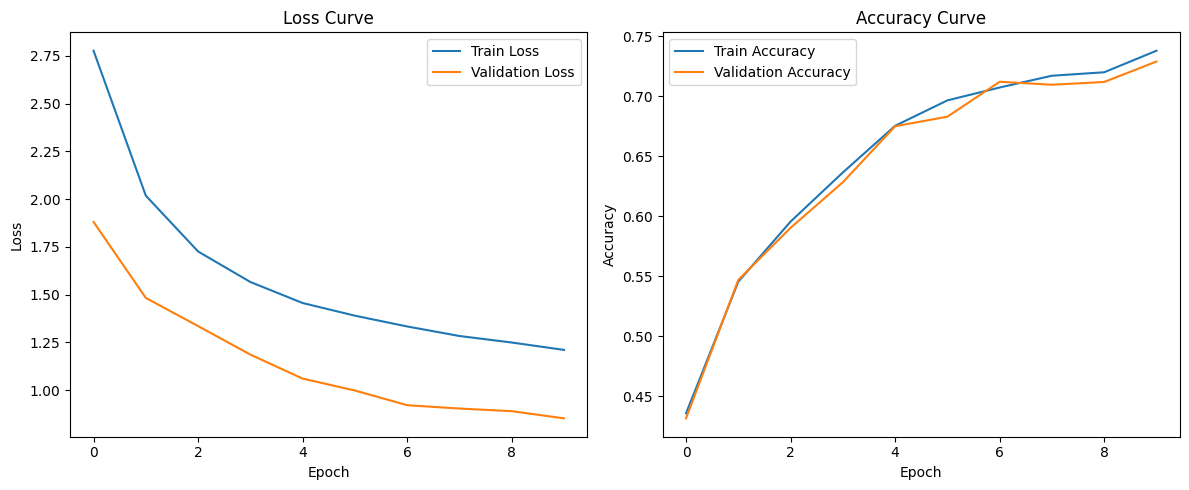

In [22]:
# Evaluate on test set
y_pred = nn.predict(X_test)
print("\nFinal Test Set Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png')
# plt.close()

# Loss and accuracy curves for final model
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Loss Curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(train_accuracies, label='Train Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title('Accuracy Curve')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.tight_layout()
plt.savefig('loss_accuracy_plot.png')
# plt.close()